# FISH comparison

Data: https://drive.google.com/drive/folders/1uos3DDymyrh3ZyxveDhqQIcOyD1brxeL

In [3]:
import pandas as pd
import seaborn as sns
import scanpy as sc
import scipy.sparse as sparse
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import itertools

In [4]:
dropseq = pd.read_csv('/data_volume/memento/saver/melanoma_dropseq.csv', index_col=0, sep=',').T

In [5]:
smfish = pd.read_csv('/data_volume/memento/saver/fishSubset.txt', index_col=0, sep=' ')
# smfish = pd.read_csv('fishSubset (1).txt', sep=' ', index_col=0)

In [6]:
saver_estimates = pd.read_csv('/data_volume/memento/saver/saver_estimates.csv', index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: '/data_volume/memento/saver/saver_estimates.csv'

In [ ]:
def concordance(x, y, log=False):
    
    nonnan = np.isfinite(x) & np.isfinite(y)
    
    if log:
        a = np.log(x)
        b = np.log(y)
    else:
        a = x
        b = y
    cond = np.isfinite(a) & np.isfinite(b)
    a = a[cond]
    b = b[cond]
    cmat = np.cov(a, b)
    return 2*cmat[0,1]/(cmat[0,0] + cmat[1,1] + (a.mean()-b.mean())**2)

### Run memento for DropSeq

In [ ]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.8-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [ ]:
adata = sc.AnnData(X=sparse.csr_matrix(dropseq.values), obs=pd.DataFrame(index=dropseq.index), var=pd.DataFrame(index=dropseq.columns))

In [ ]:
# sc.pp.filter_cells(adata, min_counts=500,)
# sc.pp.filter_cells(adata, max_counts=10000)

In [ ]:
q = 0.01485030176341905
adata.obs['q'] = q

In [ ]:
adata.obs['group'] = 'A'

In [ ]:
memento.setup_memento(adata, q_column='q', filter_mean_thresh=0.02,trim_percent=0.1)

In [ ]:
plt.scatter(
    np.log(adata.uns['memento']['all_1d_moments'][0]),
    np.log(adata.uns['memento']['all_1d_moments'][1]), s=1)

In [ ]:
memento.estimator._fit_mv_regressor(adata.uns['memento']['all_1d_moments'][0], adata.uns['memento']['all_1d_moments'][1])

In [3]:
# size_factor = adata[:, 'GAPDH'].X.todense().A1+1
adata.obs['memento_size_factor'] = 2000#adata.obs['memento_size_factor']#/adata.obs['memento_size_factor'].mean()

NameError: name 'adata' is not defined

In [352]:
memento.create_groups(adata, label_columns=['group'])

In [353]:
memento.compute_1d_moments(adata, filter_genes=True)

In [354]:
dropseq_m, dropseq_v, _ = adata.uns['memento']['1d_moments']['sg^A']
dropseq_fano = dropseq_v/dropseq_m**2

In [355]:
naive_m, naive_v = adata.X.mean(axis=0).A1, adata.X.toarray().var(axis=0)
naive_fano = naive_v/naive_m**2

In [356]:
adata.obs.head(5)

,q,group,memento_size_factor,memento_group
CTCGCGAGTAGC,0.01485,A,2000,sg^A
CGGAGGCACTCG,0.01485,A,2000,sg^A
GCAAGTCGATAT,0.01485,A,2000,sg^A
GGACAATTTGTA,0.01485,A,2000,sg^A
TGACAATTGACC,0.01485,A,2000,sg^A


### Compute fish mean and variance

In [357]:
set(smfish.columns)-set(adata.var.index.tolist())

{'AXL',
 'C1S',
 'EGFR',
 'JUN',
 'LOXL2',
 'NGFR',
 'NRG1',
 'PDGFC',
 'PDGFRB',
 'SERPINE1',
 'VEGFC',
 'WNT5A'}

In [358]:
keep_genes = smfish.columns.tolist()

In [359]:
overlap_genes = list(set(adata.var.index) & set(keep_genes))

In [360]:
overlap_gene_idxs = np.array([adata.var.index.tolist().index(g) for g in overlap_genes])

In [361]:
len(overlap_genes)

14

In [362]:
dropseq_m, dropseq_v, naive_m, naive_v = dropseq_m[overlap_gene_idxs], dropseq_v[overlap_gene_idxs], naive_m[overlap_gene_idxs], naive_v[overlap_gene_idxs]
dropseq_fano, naive_fano = dropseq_fano[overlap_gene_idxs], naive_fano[overlap_gene_idxs]

In [363]:
test = smfish[overlap_genes]

In [364]:
filtered_smfish = smfish[overlap_genes]

In [365]:
a, b, _, _, _= stats.linregress(np.log(means), np.log(variances))
rv = np.log(variances)-(np.log(means)*a+b)

In [366]:
means = np.nanmean(filtered_smfish, axis=0)
variances = np.nanvar(filtered_smfish, axis=0)
corrs = filtered_smfish.corr()
covs = filtered_smfish.cov()
fanos = variances/means**2

a, b, _, _, _= stats.linregress(np.log(means), np.log(variances))
rv = np.log(variances)-(np.log(means)*a+b)

In [367]:
naive_corr = np.corrcoef(adata[:, overlap_genes].X.todense(), rowvar=False)
naive_cov = np.cov(adata[:, overlap_genes].X.todense(), rowvar=False)

a, b, _, _, _= stats.linregress(np.log(dropseq_m), np.log(dropseq_v))
dropseq_rv = np.log(dropseq_v)-(np.log(dropseq_m)*a+b)

In [368]:
a, b, _, _, _= stats.linregress(np.log(naive_m), np.log(naive_v))
naive_rv = np.log(naive_v)-(np.log(naive_m)*a+b)

In [369]:
corrs.shape

(14, 14)

In [370]:
saver_corrs = pd.read_csv('/data_volume/memento/saver/saver_corrs.csv', index_col=0).loc[overlap_genes, overlap_genes].values.reshape(-1)

### Make comparisons for variances

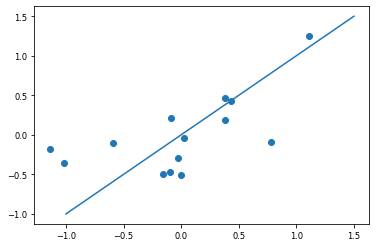

In [371]:
plt.scatter(rv, naive_rv)
plt.plot([-1, 1.5],[-1, 1.5])

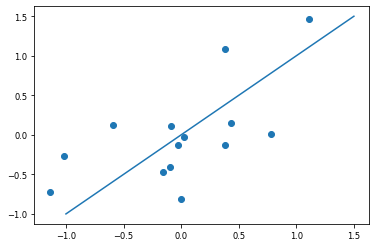

In [372]:
plt.scatter(rv, dropseq_rv)
plt.plot([-1, 1.5],[-1, 1.5])

In [373]:
concordance(rv, naive_rv)

0.616292801315483

In [374]:
concordance(rv, dropseq_rv)

0.6320049970032693

### Make comparison for mean and variability

In [375]:
filtered_saver = saver_estimates.T[overlap_genes]

In [376]:
saver_m = np.nanmean(filtered_saver, axis=0)
saver_v = np.nanvar(filtered_saver, axis=0)
saver_fano = saver_v/saver_m**2

a, b, _, _, _= stats.linregress(np.log(saver_m), np.log(saver_v))
naive_rv = np.log(saver_v)-(np.log(saver_m)*a+b)

In [377]:
n_umi = adata.obs['memento_size_factor'].mean()

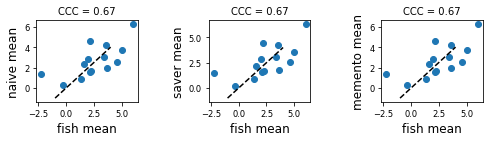

In [378]:
plt.figure(figsize=(8,1.5))
plt.subplots_adjust(wspace=0.7)

plt.subplot(1,3,1)
plt.scatter(np.log(means), np.log(naive_m/q))
plt.plot([-1, 4],[-1, 4], '--', color='k')
plt.xlabel('fish mean'); plt.ylabel('naive mean')
plt.title('CCC = '+str.format('{0:.2f}', concordance(np.log(means), np.log(naive_m/q))))

plt.subplot(1,3,2)
plt.scatter(np.log(means), np.log(saver_m/q))
plt.plot([-1, 4],[-1, 4], '--', color='k')
plt.xlabel('fish mean'); plt.ylabel('saver mean')
# print('saver', stats.pearsonr(fish_corr_array[selected_pairs], saver_corrs[selected_pairs])[0])
plt.title('CCC = '+str.format('{0:.2f}', concordance(np.log(means), np.log(saver_m/q))))

plt.subplot(1,3,3)
plt.scatter(np.log(means), np.log(dropseq_m*n_umi/q))
plt.plot([-1, 4],[-1, 4], '--', color='k')
plt.xlabel('fish mean'); plt.ylabel('memento mean')
plt.title('CCC = '+str.format('{0:.2f}', concordance(np.log(means), np.log(dropseq_m*n_umi/q))))

plt.savefig('mean_comparisons.png', dpi=300)

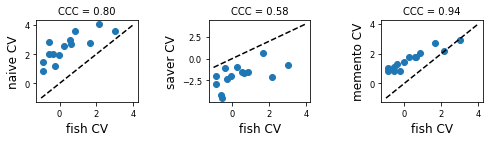

In [391]:
plt.figure(figsize=(8,1.5))
plt.subplots_adjust(wspace=0.7)

plt.subplot(1,3,1)
plt.scatter(np.log(fanos), np.log(naive_fano))
plt.plot([-1, 4],[-1, 4], '--', color='k')
plt.xlabel('fish CV'); plt.ylabel('naive CV')
plt.title('CCC = '+str.format('{0:.2f}', stats.pearsonr(np.log(fanos), np.log(naive_fano))[0]))

plt.subplot(1,3,2)
plt.scatter(np.log(fanos), np.log(saver_fano))
plt.plot([-1, 4],[-1, 4], '--', color='k')
plt.xlabel('fish CV'); plt.ylabel('saver CV')
# print('saver', stats.pearsonr(fish_corr_array[selected_pairs], saver_corrs[selected_pairs])[0])
plt.title('CCC = '+str.format('{0:.2f}', stats.pearsonr(np.log(fanos), np.log(saver_fano))[0]))

plt.subplot(1,3,3)
plt.scatter(np.log(fanos), np.log(dropseq_fano))
plt.plot([-1, 4],[-1, 4], '--', color='k')
plt.xlabel('fish CV'); plt.ylabel('memento CV')
plt.title('CCC = '+str.format('{0:.2f}', stats.pearsonr(np.log(fanos), np.log(dropseq_fano))[0]))

plt.savefig('variability_comparisons.png', dpi=300)

### Make comparison for correlations

In [380]:
memento.compute_2d_moments(adata, gene_pairs=list(itertools.product(overlap_genes, overlap_genes)))

In [381]:
memento_corr_array = adata.uns['memento']['2d_moments']['sg^A']['corr']
memento_cov_array = adata.uns['memento']['2d_moments']['sg^A']['cov']

In [382]:
fish_corr_array = np.array([corrs.loc[x,y] for x,y in itertools.product(overlap_genes, overlap_genes)])
fish_cov_array = np.array([covs.loc[x,y] for x,y in itertools.product(overlap_genes, overlap_genes)])

In [383]:
selected_pairs = ~np.isnan(fish_corr_array) & (fish_corr_array!=1)

In [384]:
selected_pairs.shape

(196,)

In [385]:
stats.pearsonr(fish_corr_array[selected_pairs], naive_corr.reshape(-1)[selected_pairs])

(0.6712335140251099, 3.232066934178155e-11)

In [386]:
stats.pearsonr(fish_corr_array[selected_pairs], saver_corrs[selected_pairs])

(0.7783984553717122, 1.283160846829749e-16)

In [387]:
stats.pearsonr(fish_corr_array[selected_pairs], memento_corr_array[selected_pairs])

(0.7909050220217189, 1.9088535836388513e-17)

In [388]:
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'large',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


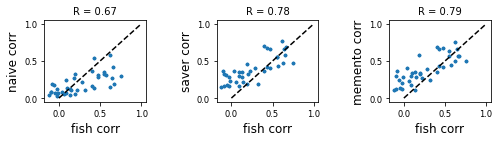

In [392]:
plt.figure(figsize=(8,1.5))
plt.subplots_adjust(wspace=0.7)

plt.subplot(1,3,1)
plt.scatter(fish_corr_array[selected_pairs], naive_corr.reshape(-1)[selected_pairs], s=7)
plt.plot([0,1], [0,1], '--',color='k')
plt.xlabel('fish corr'); plt.ylabel('naive corr')
# print('naive', stats.pearsonr(fish_corr_array[selected_pairs], naive_corr.reshape(-1)[selected_pairs])[0])
plt.title('R = '+str(concordance(fish_corr_array[selected_pairs], naive_corr.reshape(-1)[selected_pairs])))
plt.title('R = '+str.format('{0:.2f}', stats.pearsonr(fish_corr_array[selected_pairs], naive_corr.reshape(-1)[selected_pairs])[0]))



plt.subplot(1,3,2)
plt.scatter(fish_corr_array[selected_pairs], saver_corrs[selected_pairs], s=7)
plt.plot([0,1], [0,1], '--',color='k')
plt.xlabel('fish corr'); plt.ylabel('saver corr')
# print('saver', stats.pearsonr(fish_corr_array[selected_pairs], saver_corrs[selected_pairs])[0])
plt.title('R = '+str(concordance(fish_corr_array[selected_pairs], saver_corrs[selected_pairs])))
plt.title('R = '+str.format('{0:.2f}', stats.pearsonr(fish_corr_array[selected_pairs], saver_corrs[selected_pairs])[0]))

plt.subplot(1,3,3)
plt.scatter(fish_corr_array[selected_pairs], memento_corr_array[selected_pairs], s=7)
plt.plot([0,1], [0,1], '--',color='k')
plt.xlabel('fish corr'); plt.ylabel('memento corr')
# print('memento', stats.pearsonr(fish_corr_array[selected_pairs], memento_corr_array[selected_pairs])[0])
plt.title('R = '+str.format('{0:.2f}', stats.pearsonr(fish_corr_array[selected_pairs], memento_corr_array[selected_pairs])[0]))

plt.savefig('coex_comparisons.png', dpi=300)